# An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lab1').getOrCreate()

## Explore data

In [2]:
df = spark.read.csv('data/ccdefault.csv', header=True, inferSchema=True)

### Schema

In [3]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

### Size

In [4]:
df.count()

30000

### Look at data

In [5]:
df.limit(5).toPandas()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Import and configure dependencies for aggregating and visualizing

### Visualize distributions of some variables

In [6]:
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("fivethirtyeight")

#### Distribution of sex

In [7]:
df_sex = df.groupBy("SEX").count().sort(asc("SEX")).toPandas()
df_sex

,SEX,count
0,1,11888
1,2,18112


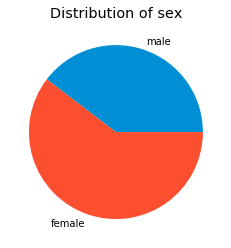

In [8]:
labels = ["male", "female"]
plt.pie(df_sex['count'], labels=labels);
plt.title('Distribution of sex');

#### Distribution of education

In [9]:
df_education = df.groupBy("EDUCATION").count().sort(asc("EDUCATION")).toPandas()
df_education

,EDUCATION,count
0,0,14
1,1,10585
2,2,14030
3,3,4917
4,4,123
5,5,280
6,6,51


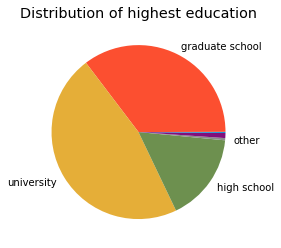

In [10]:
labels = ["", "graduate school", "university", "high school", "other", "", ""]
plt.pie(df_education['count'], labels=labels);
plt.title('Distribution of highest education');

#### Distribution of relationship status

In [11]:
df_marriage = df.groupBy("MARRIAGE").count().sort(asc("MARRIAGE")).toPandas()
df_marriage

,MARRIAGE,count
0,0,54
1,1,13659
2,2,15964
3,3,323


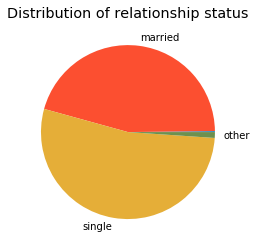

In [12]:
labels = ["", "married", "single", "other"]
plt.pie(df_marriage['count'], labels=labels);
plt.title('Distribution of relationship status');

#### Distribution of ages

In [13]:
df_age = df.groupBy("AGE").count().sort(asc("AGE")).toPandas()

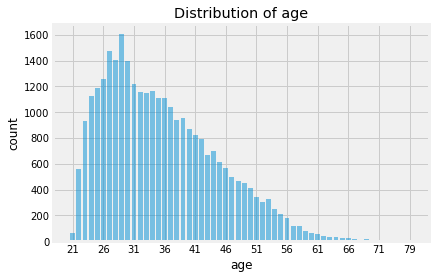

In [14]:
import numpy as np
x_pos = np.arange(df_age["AGE"].size)
x_tick_pos = x_pos[0::5]
x_tick_labels = df_age["AGE"][0::5]
plt.bar(x_pos, df_age["count"], align='center', alpha=0.5);
plt.xticks(x_tick_pos, x_tick_labels);
plt.xlabel('age');
plt.ylabel('count');
plt.title('Distribution of age');

#### Distribution of given credit

In [15]:
df_credit = df.select("LIMIT_BAL").toPandas()
df_credit

,LIMIT_BAL
0,20000
1,120000
2,90000
3,50000
4,50000
...,...
29995,220000
29996,150000
29997,30000
29998,80000


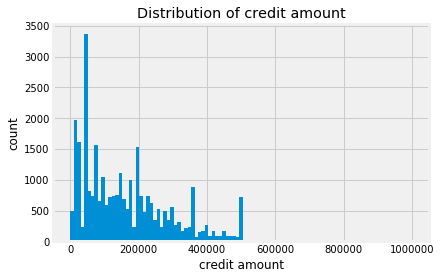

In [16]:
bins = np.linspace(0, 1000000, 100)
plt.hist(df_credit["LIMIT_BAL"], bins=bins)
plt.xlabel('credit amount');
plt.ylabel('count');
plt.title('Distribution of credit amount');

#### Distribution PAY_X

In [17]:
import pandas as pd

df_pay = df.select("PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6").toPandas()
df_pay.apply(pd.Series.value_counts)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
-2,2759,3782,4085,4348,4546.0,4895.0
-1,5686,6050,5938,5687,5539.0,5740.0
0,14737,15730,15764,16455,16947.0,16286.0
1,3688,28,4,2,NaN,NaN
2,2667,3927,3819,3159,2626.0,2766.0
3,322,326,240,180,178.0,184.0
4,76,99,76,69,84.0,49.0
5,26,25,21,35,17.0,13.0
6,11,12,23,5,4.0,19.0
7,9,20,27,58,58.0,46.0


In [18]:
# from: https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook

def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

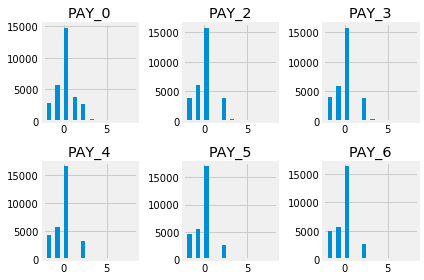

In [19]:
draw_histograms(df_pay, df_pay.columns, 2, 3, 20)

#### Distribution BILL_AMTX

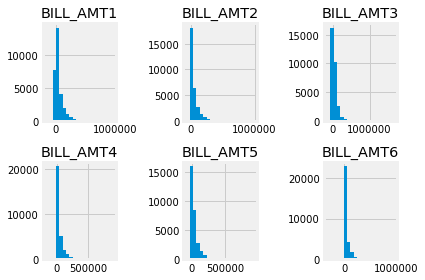

In [20]:
df_bill = df.select("BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6").toPandas()
draw_histograms(df_bill, df_bill.columns, 2, 3, 20)

#### Distribution PAY_AMTX

In [ ]:
df_pay_amt = df.select("PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6").toPandas()
draw_histograms(df_pay_amt, df_pay_amt.columns, 2, 3, 30)

#### Distribution of defaults

In [ ]:
df_defaults = df.groupBy("DEFAULT").count().sort(asc("DEFAULT")).toPandas()
df_defaults

In [ ]:
labels = ["no", "yes"]
plt.pie(df_defaults['count'], labels=labels);
plt.title('Distribution of defaults');

### Baseline

In [ ]:
df_defaults['count'][0]/(df_defaults['count'][0]+df_defaults['count'][1])

A model that only predicts "no default" will have an accuracy of 77.88%

## Prepare data

In [ ]:
df = df.withColumnRenamed("DEFAULT", "label").drop("ID")
df.printSchema()

Divide columns into label, numerical and categorical columns

In [ ]:
# label column
col_label = ["label"]

# categorical columns
col_cat = ["SEX", "EDUCATION", "MARRIAGE"]

# numerical columns
col_cont = [col for col in df.columns if col not in col_label and col not in col_cat]

Check for null values

In [ ]:
for c in col_cont:
    print(c, df.where(col(c).isNull()).count())

In [ ]:
for c in col_cat:
    print(c, df.where(col(c).isNull()).count())

In [ ]:
print("label", df.where(col("label").isNull()).count())

### Scaler for continuous features

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler_cont = VectorAssembler(
    inputCols=col_cont,
    outputCol="features_continuous")

scaler_cont = StandardScaler(inputCol="features_continuous", outputCol="features_continuous_scaled")

### One-hot encoder for categorical features

One-hot encoder for sex

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer_sex = StringIndexer(inputCol="SEX", outputCol="sex_index")
encoder_sex = OneHotEncoder(inputCol="sex_index", outputCol="sex_vec")

One-hot encoder for education

In [ ]:
indexer_education = StringIndexer(inputCol="EDUCATION", outputCol="education_index")
encoder_education = OneHotEncoder(inputCol="education_index", outputCol="education_vec")

One-hot encoder for marriage

In [ ]:
indexer_marriage = StringIndexer(inputCol="MARRIAGE", outputCol="marriage_index")
encoder_marriage = OneHotEncoder(inputCol="marriage_index", outputCol="marriage_vec")

Assembler to combine all encoded and scaled features

In [ ]:
columns = ['features_continuous_scaled', 'sex_vec', 'education_vec', 'marriage_vec']
assembler_all = VectorAssembler(
    inputCols=columns,
    outputCol="features")

### Create pipeline

In [ ]:
from pyspark.ml import Pipeline

pipeline_cont = Pipeline(stages=[assembler_cont, scaler_cont])
pipeline_cat = Pipeline(stages=[indexer_sex, encoder_sex, indexer_education, encoder_education, indexer_marriage, encoder_marriage])
pipeline = Pipeline(stages=[pipeline_cont, pipeline_cat, assembler_all])

### Scale and encode features

In [ ]:
dataset = pipeline.fit(df).transform(df).select("features", "label")

Show features and label (last column) for 10 instances 

In [ ]:
from IPython.display import HTML, display
def display_dataset(dataset, n=10):
    display(HTML(
       '<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td><td>{}</td>'.format('</td><td>'.join('%.2f' % _ for _ in row[0]), row[1]) for row in dataset.head(n=n))
           )
    ))

In [ ]:
display_dataset(dataset, n=10)

### Split into training and test data

In [ ]:
(train_set, test_set) = dataset.randomSplit([0.7, 0.3], seed=0)

In [ ]:
train_set.count()

In [ ]:
test_set.count()

## Models

### Evaluation metrics

In [ ]:
def get_accuracy(predictions):
    correct = predictions.filter(predictions.label == predictions.prediction).count()
    total = predictions.count()
    return correct/total

def get_precision(predictions):
    tp = predictions.filter(predictions.label == 1).filter(predictions.prediction == 1).count()
    tp_fp = predictions.filter(predictions.prediction == 1).count()
    return tp / tp_fp

def get_recall(predictions):
    tp = predictions.filter(predictions.label == 1).filter(predictions.prediction == 1).count()
    tp_fn = predictions.filter(predictions.label == 1).count()
    return tp/tp_fn

def get_f1(predictions):
    p = get_precision(predictions)
    r = get_recall(predictions)
    return 2*(p*r)/(p+r)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator().setMetricName('areaUnderROC')

### Logistic regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

lr = LogisticRegression(maxIter=10)
lr_model = lr.fit(train_set)

predictions = lr_model.transform(test_set)
predictions.limit(5).toPandas()

In [ ]:
# Adapted from: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def get_probs_and_labels(predictions):
    return predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

In [ ]:
# Returns as a list (false positive rate, true positive rate)
probs_labels = get_probs_and_labels(predictions)
roc = CurveMetrics(probs_labels).get_curve('roc')
pr = CurveMetrics(probs_labels).get_curve('pr')

In [ ]:
def plot_curve(xxyy, xlabel, ylabel):
    x_val = [e[0] for e in xxyy]
    y_val = [e[1] for e in xxyy]
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_val, y_val);

In [ ]:
plot_curve(roc, xlabel="FPR", ylabel="TPR")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in roc]
yy = [x[1] for x in roc]
auc(xx, yy)

In [ ]:
auc = evaluator.evaluate(predictions)
auc

In [ ]:
plot_curve(pr, xlabel="Recall", ylabel="Precision")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in pr]
yy = [x[1] for x in pr]
auc(xx, yy)

In [ ]:
get_precision(predictions)

In [ ]:
get_recall(predictions)

In [ ]:
get_f1(predictions)

In [ ]:
get_accuracy(predictions)

### Decision tree classification

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(maxDepth=10)
dt_model = dt.fit(train_set)

predictions = dt_model.transform(test_set)
predictions.limit(5).toPandas()

In [ ]:
# Returns as a list (false positive rate, true positive rate)
probs_labels = get_probs_and_labels(predictions)
roc = CurveMetrics(probs_labels).get_curve('roc')
pr = CurveMetrics(probs_labels).get_curve('pr')
plot_curve(roc, xlabel="FPR", ylabel="TPR")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in roc]
yy = [x[1] for x in roc]
auc(xx, yy)

In [ ]:
auc = evaluator.evaluate(predictions)  # this result looks wrong
auc

In [ ]:
plot_curve(pr, xlabel="Recall", ylabel="Precision")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in pr]
yy = [x[1] for x in pr]
auc(xx, yy)

In [ ]:
get_precision(predictions)

In [ ]:
get_recall(predictions)

In [ ]:
get_f1(predictions)

In [ ]:
get_accuracy(predictions)

### Random forest classification

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(maxDepth=10)
rf_model = rf.fit(train_set)

predictions = rf_model.transform(test_set)
predictions.limit(5).toPandas()

In [ ]:
# Returns as a list (false positive rate, true positive rate)
probs_labels = get_probs_and_labels(predictions)
roc = CurveMetrics(probs_labels).get_curve('roc')
pr = CurveMetrics(probs_labels).get_curve('pr')
plot_curve(roc, xlabel="FPR", ylabel="TPR")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in roc]
yy = [x[1] for x in roc]
auc(xx, yy)

In [ ]:
auc = evaluator.evaluate(predictions)
auc

In [ ]:
plot_curve(pr, xlabel="Recall", ylabel="Precision")

In [ ]:
from sklearn.metrics import auc
xx = [x[0] for x in pr]
yy = [x[1] for x in pr]
auc(xx, yy)

In [ ]:
get_precision(predictions)

In [ ]:
get_recall(predictions)

In [ ]:
get_f1(predictions)

In [ ]:
get_accuracy(predictions)

### Conclusion

|                       | LRC       | DTC           | RFC         |
| -------------------   |-----     |------          |-----        |
| Area under ROC curve (AUC)  | 0.72     |0.73            |**0.78**     |
| Area under PR curve   | 0.51     |0.47            |**0.56**     |

A comparison of the AUC for each of these models shows that the random forest classifier (RFC) achieves the highest AUC with 0.78, followed by the decision tree classifier (DTC) with 0.73 and the logistic regression classifier (LRC) with 0.72.

But because of the class imbalance, it might be better to look at the precision and recall.

The random forest classifier (RFC) achieves the highest area under PR curve with 0.56, followed by the logistic regression classifier (LRC) with 0.51 and the decision tree classifier (DTC) with 0.47.

The decision threshold was not adapted for any of the models. But for the default value, we can say the following:

The precision is highest for LRC. 0.73% of the times it predicted credit card default it was correct. Followed by 
RFC with 0.67% and DTC with 0.62%.

The recall is low for all of the models. They are all having trouble finding the credit card defaults. Recall was highest for RFC with 0.34%, meaning that it found 34% of the credit card defaults. Followed by DTC with 0.32 and LRC with 0.23.

The logistic regression classifier is best suited if it is more important to be be confident about the default predictions since its precision is the highest. The random forest classifier with the highest recall is best suited, if it is important to find as many credit card defaults as possible, at the the cost of precision.


The choice of model ultimately depends on the cost of making two different kinds of wrong decision. If a missed credit card default is to be avoided but predicting a creditcard default where there is none is okay, then optimizing for high recall makes sense. Optimizing for higher precision is the way to go, if it is critical that when a credit card default is predicted the result is reliable.

### Next steps
- Gather domain specific knowledge
- Look at the data more closely and do some feature engineering
- Hyperparameter tuning, including decision threshold